In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import check_random_state
from scipy.stats import rankdata
from utils import (
    generate_synthetic_data,
    eps_greedy_policy_k,
    calc_true_value,
    aggregate_simulation_results
)
from estimators import (
    calc_cavg,
    calc_cips,
    calc_cdr
)

plt.style.use('ggplot')

### ログデータのサイズ **n** を変化させる

In [30]:
## シミュレーション設定
num_runs = 1000
dim_x = 10
num_actions = 20
beta = -3 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000, 8000]
k = 5

In [31]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))

for num_data in num_data_list:
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        M_1=M_1,
        b_1 = b_1,
        theta_0=theta_0,
        M_0=M_0,
        b_0=b_0,
        k=k,
        random_policy=True
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1,
            theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions,
            random_state = _,
            k=k, random_policy=True
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy_k(
            offline_logged_data["cate_x_a"],
            eps=0.2,
            k=k
        )

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["cavg"] = calc_cavg(offline_logged_data)
        estimated_policy_values["cips"] = calc_cips(offline_logged_data, pi)
        estimated_policy_values["cdr"] = calc_cdr(
            offline_logged_data,
            pi=pi,
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df_data = pd.concat(result_df_list).reset_index(level=0)

num_data=8000...: 100%|██████████| 1000/1000 [20:41<00:00,  1.24s/it]


In [33]:
# csvファイルに保存
result_df_data.to_csv('data/sufficient_support/result_based_n.csv', index=False)

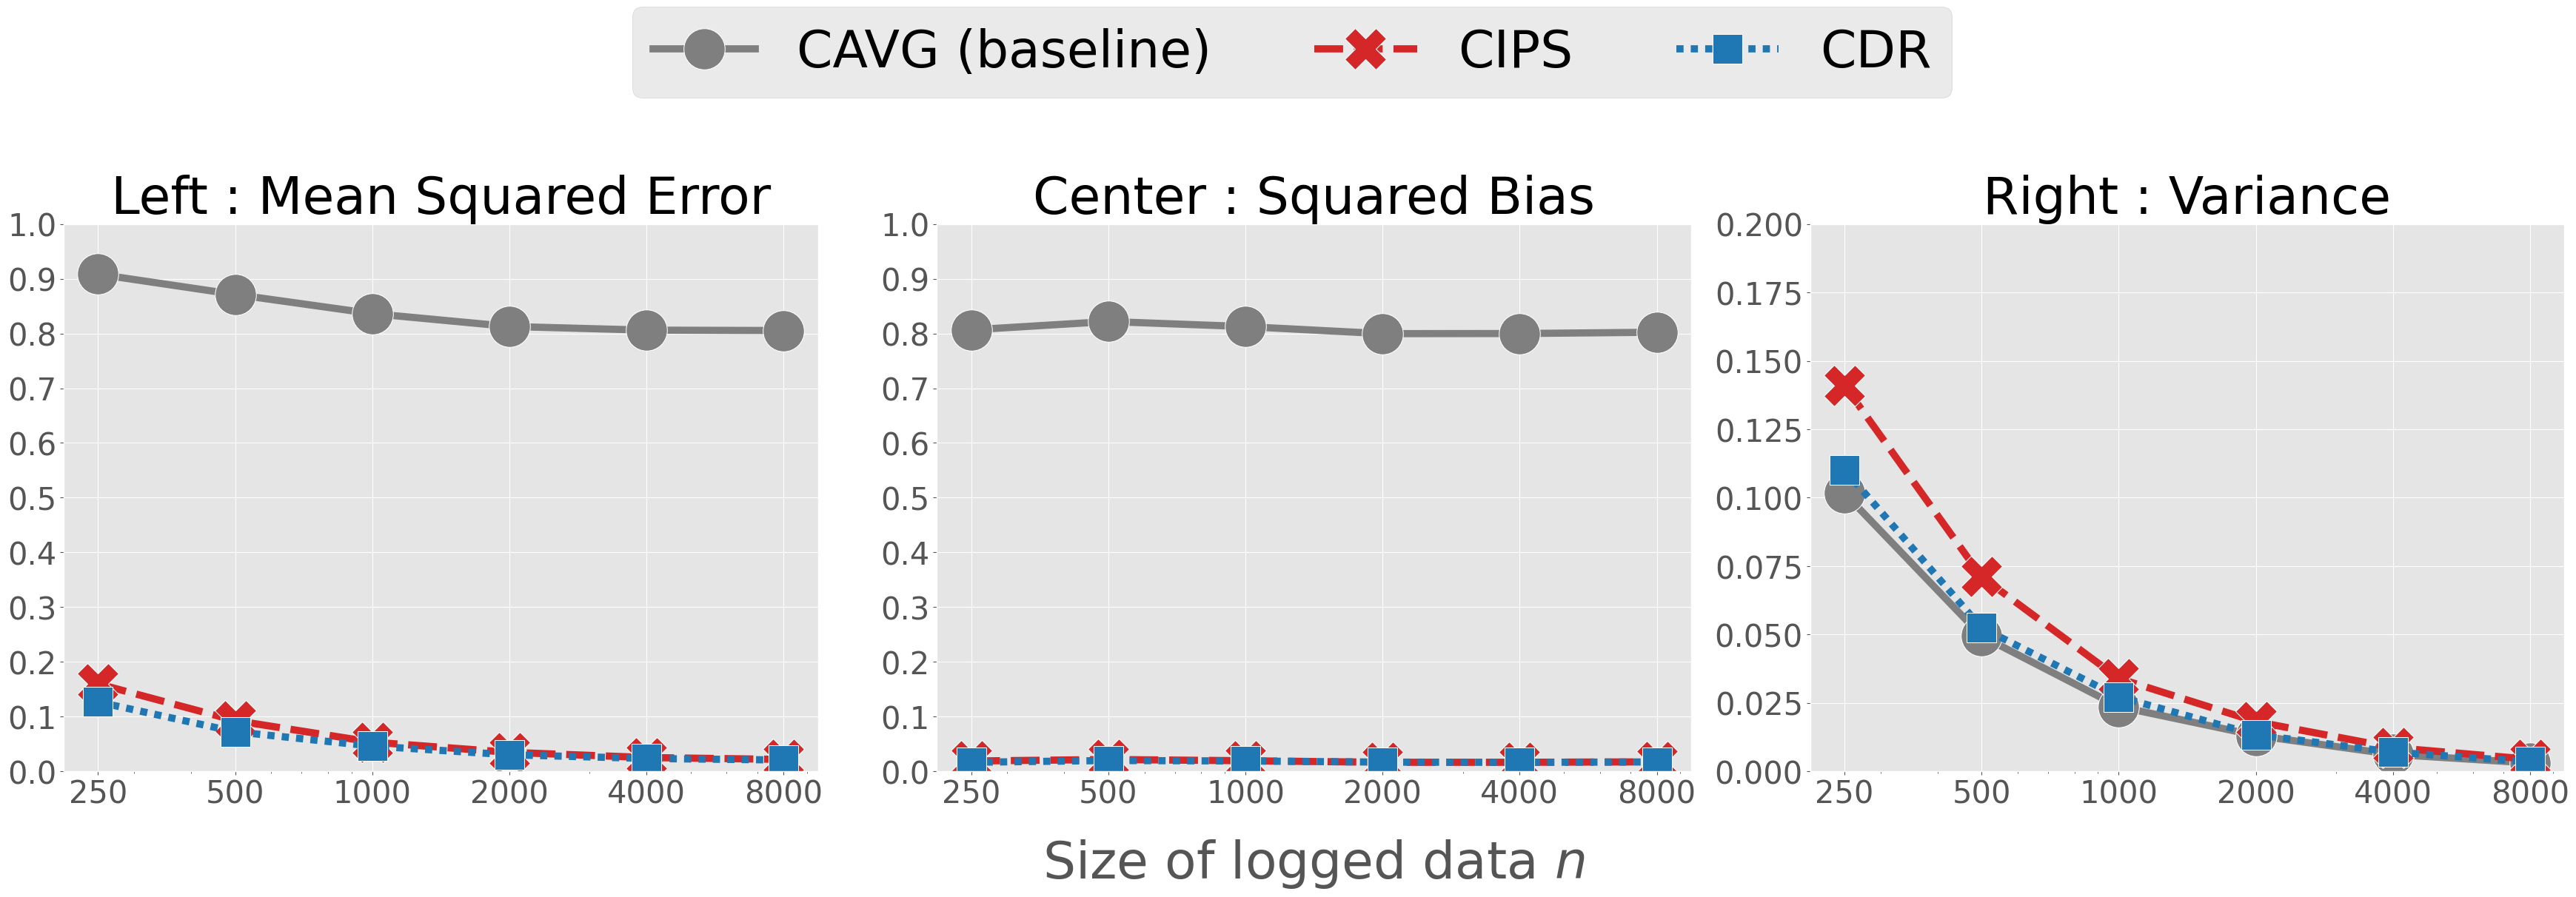

In [35]:
y_label_dict = {"se": "Left : Mean Squared Error", "bias": "Center : Squared Bias", "variance": "Right : Variance"}

fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        #palette=["tab:grey", "tab:red"],
        palette=["tab:grey", "tab:red", "tab:blue"],
        data=result_df_data,
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    if y == "se":
        ax.set_ylim(0.0, 1.0)
        ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    elif y == "bias":
        ax.set_ylim(0.0, 1.0)
        ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    elif y == "variance":
        ax.set_ylim(0.0, 0.2)
        ax.set_yticks(np.arange(0.0, 0.225, 0.025))
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"Size of logged data $n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["CAVG (baseline)", "CIPS", "CDR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")

### ログデータの行動数 **#A** を変化させる

In [60]:
## シミュレーション設定
num_runs = 5000
dim_x = 10
num_data = 500
beta = -0.2 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
num_actions_list = [100, 200, 300, 400, 500]
k = 5

In [61]:
result_df_list = []
for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    theta_1 = random_.normal(size=(dim_x, num_actions))
    M_1 = random_.normal(size=(dim_x, num_actions))
    b_1 = random_.normal(size=(1, num_actions))
    theta_0 = random_.normal(size=(dim_x, num_actions))
    M_0 = random_.normal(size=(dim_x, num_actions))
    b_0 = random_.normal(size=(1, num_actions))
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        M_1=M_1,
        b_1=b_1,
        theta_0=theta_0,
        M_0=M_0,
        b_0=b_0,
        k=k,
        random_policy=True
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions,
            random_state = _,
            k=k,
            random_policy=True
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy_k(
            offline_logged_data["cate_x_a"],
            eps=0.1,
            k=k
        )

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["cavg"] = calc_cavg(offline_logged_data)
        estimated_policy_values["cips"] = calc_cips(offline_logged_data, pi)
        estimated_policy_values["cdr"] = calc_cdr(
            offline_logged_data,
            pi=pi,
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions", num_actions,
        )
    )
result_df_actions = pd.concat(result_df_list).reset_index(level=0)

num_actions=500...: 100%|██████████| 5000/5000 [18:53<00:00,  4.41it/s]


In [62]:
# データを保存
result_df_actions.to_csv('data/sufficient_support/result_based_a_new.csv', index=False)

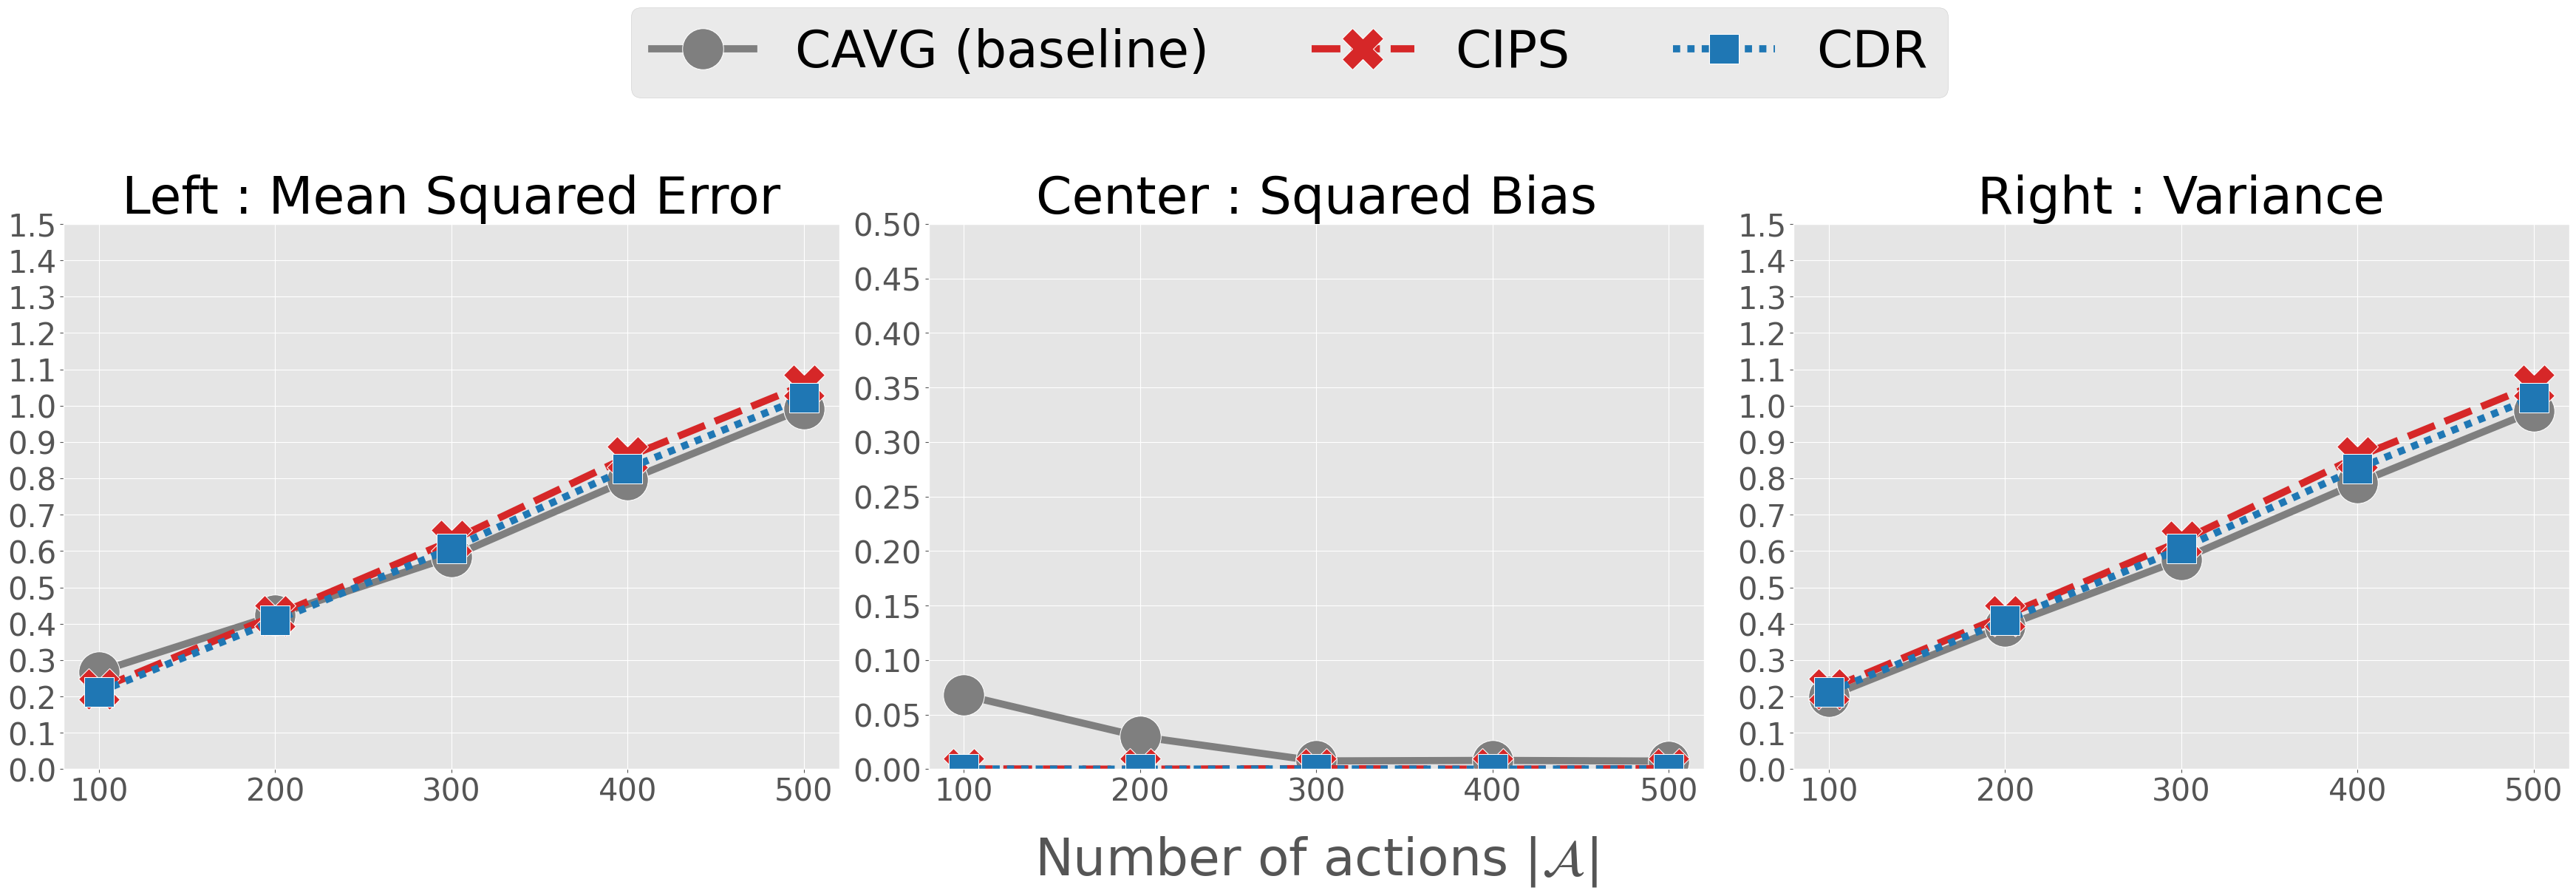

In [69]:
y_label_dict = {"se": "Left : Mean Squared Error", "bias": "Center : Squared Bias", "variance": "Right : Variance"}

fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red","tab:blue"],
        data=result_df_actions.query("est=='cavg' or est == 'cips' or est == 'cdr' ")
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    if y == "se":
        ax.set_ylim(0.0, 1.5)
        ax.set_yticks(np.arange(0.0, 1.6, 0.1))
    elif y == "bias":
        ax.set_ylim(0.0, 0.5)
        ax.set_yticks(np.arange(0.0, 0.55, 0.05))
    elif y == "variance":
        ax.set_ylim(0.0, 1.5)
        ax.set_yticks(np.arange(0.0, 1.6, 0.1))
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    # ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"Number of actions $|\mathcal{A}|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["CAVG (baseline)", "CIPS", "CDR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")

### 行動の組み合わせの要素の数 **k** を変化させる

In [19]:
## シミュレーション設定
num_runs = 5000 # シミュレーションの繰り返し回数
dim_x = 10 # 特徴量xの次元
num_data = 500 # ログデータのサイズ
num_actions = 100 # 行動数, |A|
beta = -3 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
k_list = [10, 20, 30, 40, 50]

In [13]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))

for k in k_list:  # 複数選択する行動数 k を変化
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        M_1=M_1,
        b_1=b_1,
        theta_0=theta_0,
        M_0=M_0,
        b_0=b_0,
        k = k,
        random_policy=True
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"k={k}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data,
            beta=beta,
            theta_1=theta_1,
            M_1=M_1,
            b_1=b_1,
            theta_0=theta_0,
            M_0=M_0,
            b_0=b_0,
            dim_context=dim_x,
            num_actions=num_actions,
            random_state=_,
            k=k,  # 行動要素数を指定
            random_policy=True,
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy_k(
            offline_logged_data["cate_x_a"],
            eps=0.2,
            k=k
        )

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["cavg"] = calc_cavg(offline_logged_data)
        estimated_policy_values["cips"] = calc_cips(offline_logged_data, pi)
        estimated_policy_values["cdr"] = calc_cdr(
            offline_logged_data,
            pi=pi,
            q0_hat=offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat=offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
        )

        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions_per_user", k
        )
    )

result_df_k = pd.concat(result_df_list).reset_index(level=0)


k=50...: 100%|██████████| 5000/5000 [14:29<00:00,  5.75it/s]


In [14]:
# データを保存
result_df_k.to_csv('data/sufficient_support/result_based_k.csv', index=False)

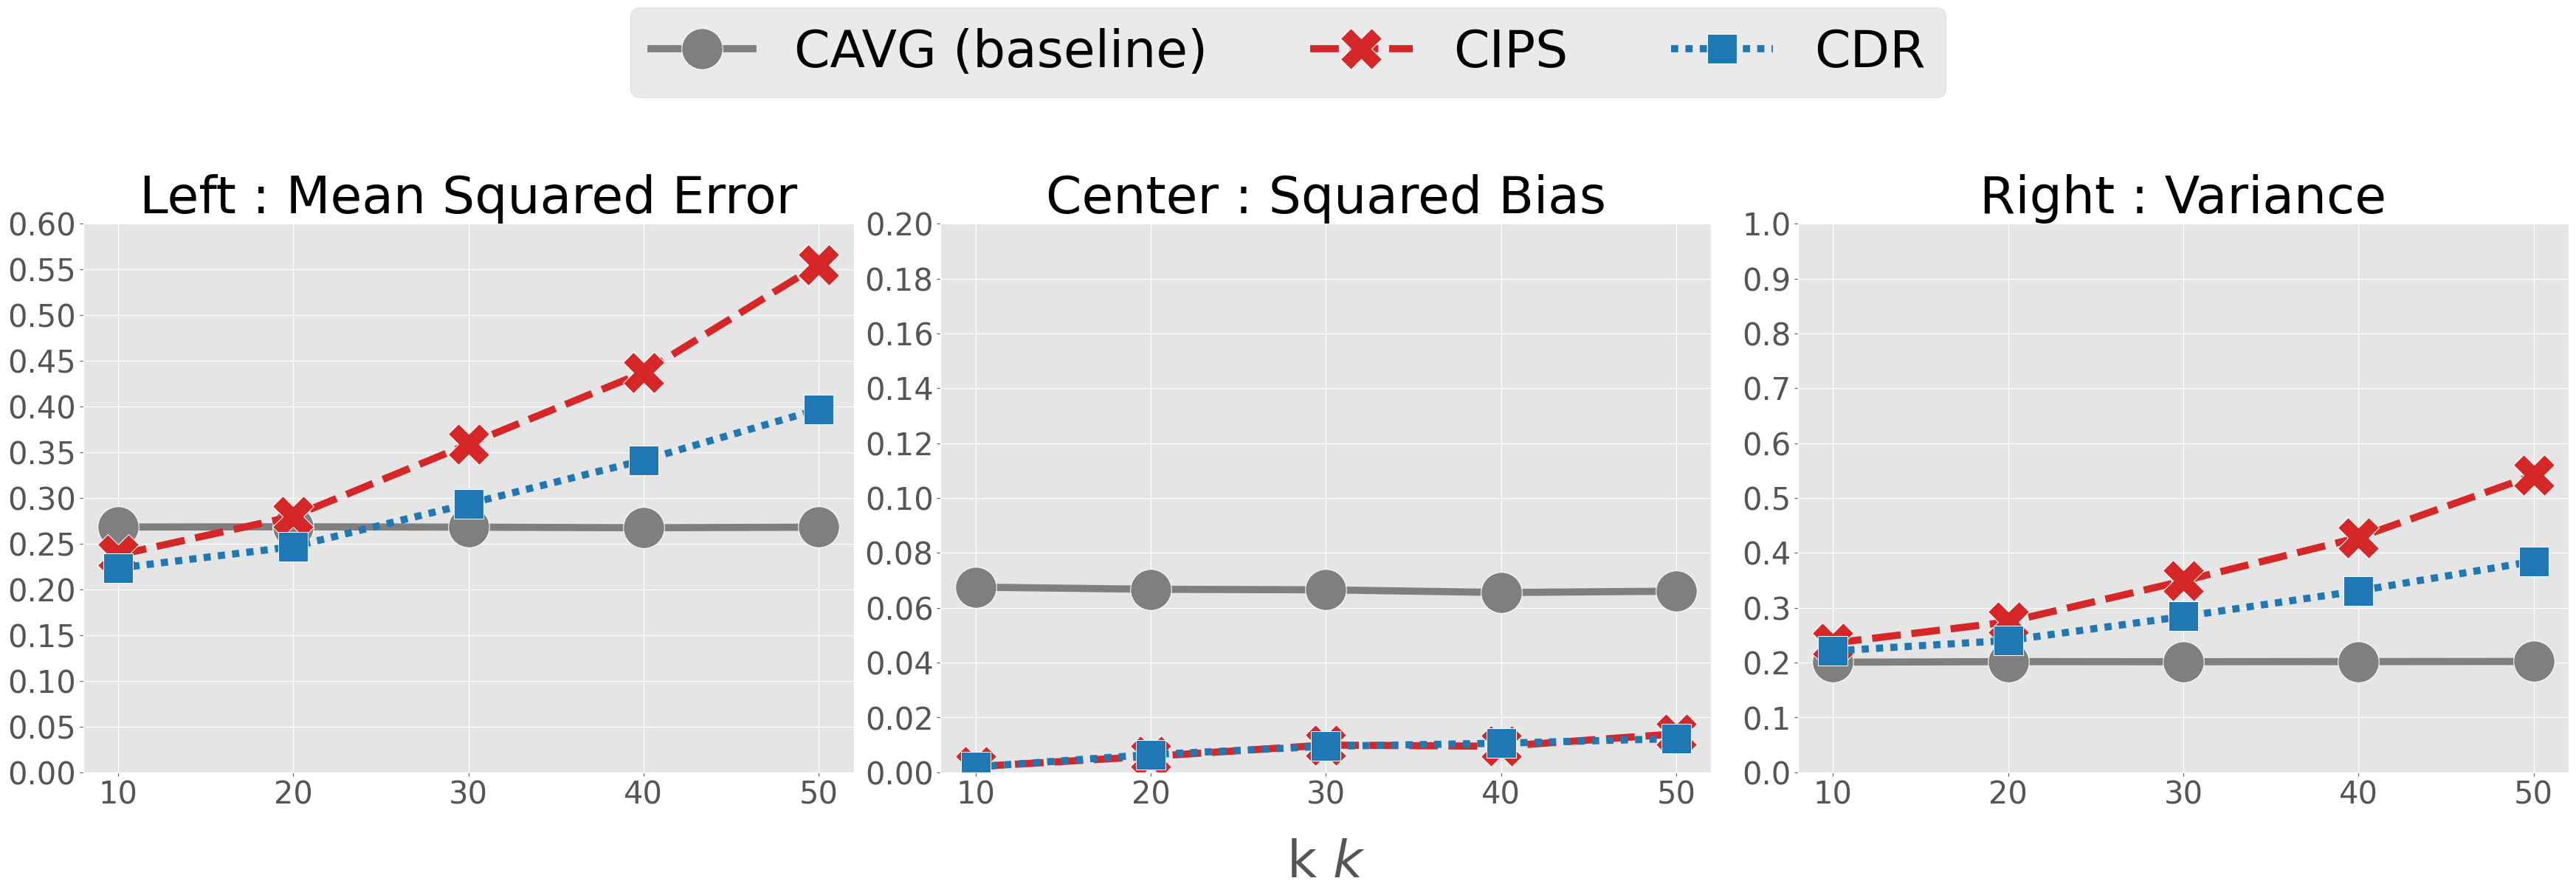

In [ ]:
y_label_dict_k = {"se": "Left : Mean Squared Error", "bias": "Center : Squared Bias", "variance": "Right : Variance"}

fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_actions_per_user",  # x軸は k
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red", "tab:blue"],
        data=result_df_k.query("est=='cavg' or est == 'cips' or est == 'cdr'")
    )
    ax.set_title(y_label_dict_k[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    if y == "se":
        ax.set_ylim(0.0, 0.6)
        ax.set_yticks(np.arange(0.0, 0.65, 0.05))
    elif y == "bias":
        ax.set_ylim(0.0, 0.2)
        ax.set_yticks(np.arange(0.0, 0.22, 0.02))
    elif y == "variance":
        ax.set_ylim(0.0, 1.0)
        ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    #ax.set_xscale("log")  # kが大きい場合の可視化のためログスケール
    if i == 1:
        ax.set_xlabel(r"Subset size $k$", fontsize=50)  # x軸ラベル
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(k_list)  # kのリストを指定
    ax.set_xticklabels(k_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["CAVG (baseline)", "CIPS", "CDR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")
plt.show()

### **共通サポートの仮定が満たされない行動の割合$|N| / |A|$を変化させる**

In [34]:
## シミュレーション設定
num_runs = 1000
dim_x = 10
num_data = 500
num_actions = 100
beta = -3 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
k = 5
num_def_actions_list = [0, 10, 20, 30, 40, 50]    

In [35]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))

for num_def_actions in num_def_actions_list:  # 複数選択する行動数 k を変化
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        M_1=M_1,
        b_1=b_1,
        theta_0=theta_0,
        M_0=M_0,
        b_0=b_0,
        k = k,
        random_policy=False
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_def_actions={num_def_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data,
            beta=beta,
            theta_1=theta_1,
            M_1=M_1,
            b_1=b_1,
            theta_0=theta_0,
            M_0=M_0,
            b_0=b_0,
            dim_context=dim_x,
            num_actions=num_actions,
            random_state=_,
            k=k,  # 行動要素数を指定
            random_policy=False,
            num_def_actions=num_def_actions
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy_k(
            offline_logged_data["cate_x_a"],
            eps=0.2,
            k=k
        )

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["cavg"] = calc_cavg(offline_logged_data)
        estimated_policy_values["cips"] = calc_cips(offline_logged_data, pi)
        estimated_policy_values["cdr"] = calc_cdr(
            offline_logged_data,
            pi=pi,
            q0_hat=offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat=offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
        )

        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_def_actions", num_def_actions / num_actions
        )
    )

result_df_def_actions = pd.concat(result_df_list).reset_index(level=0)

num_def_actions=50...: 100%|██████████| 1000/1000 [02:32<00:00,  6.54it/s]


In [37]:
# データを保存
result_df_def_actions.to_csv('data/deficient_support/result_based_def.csv', index=False)

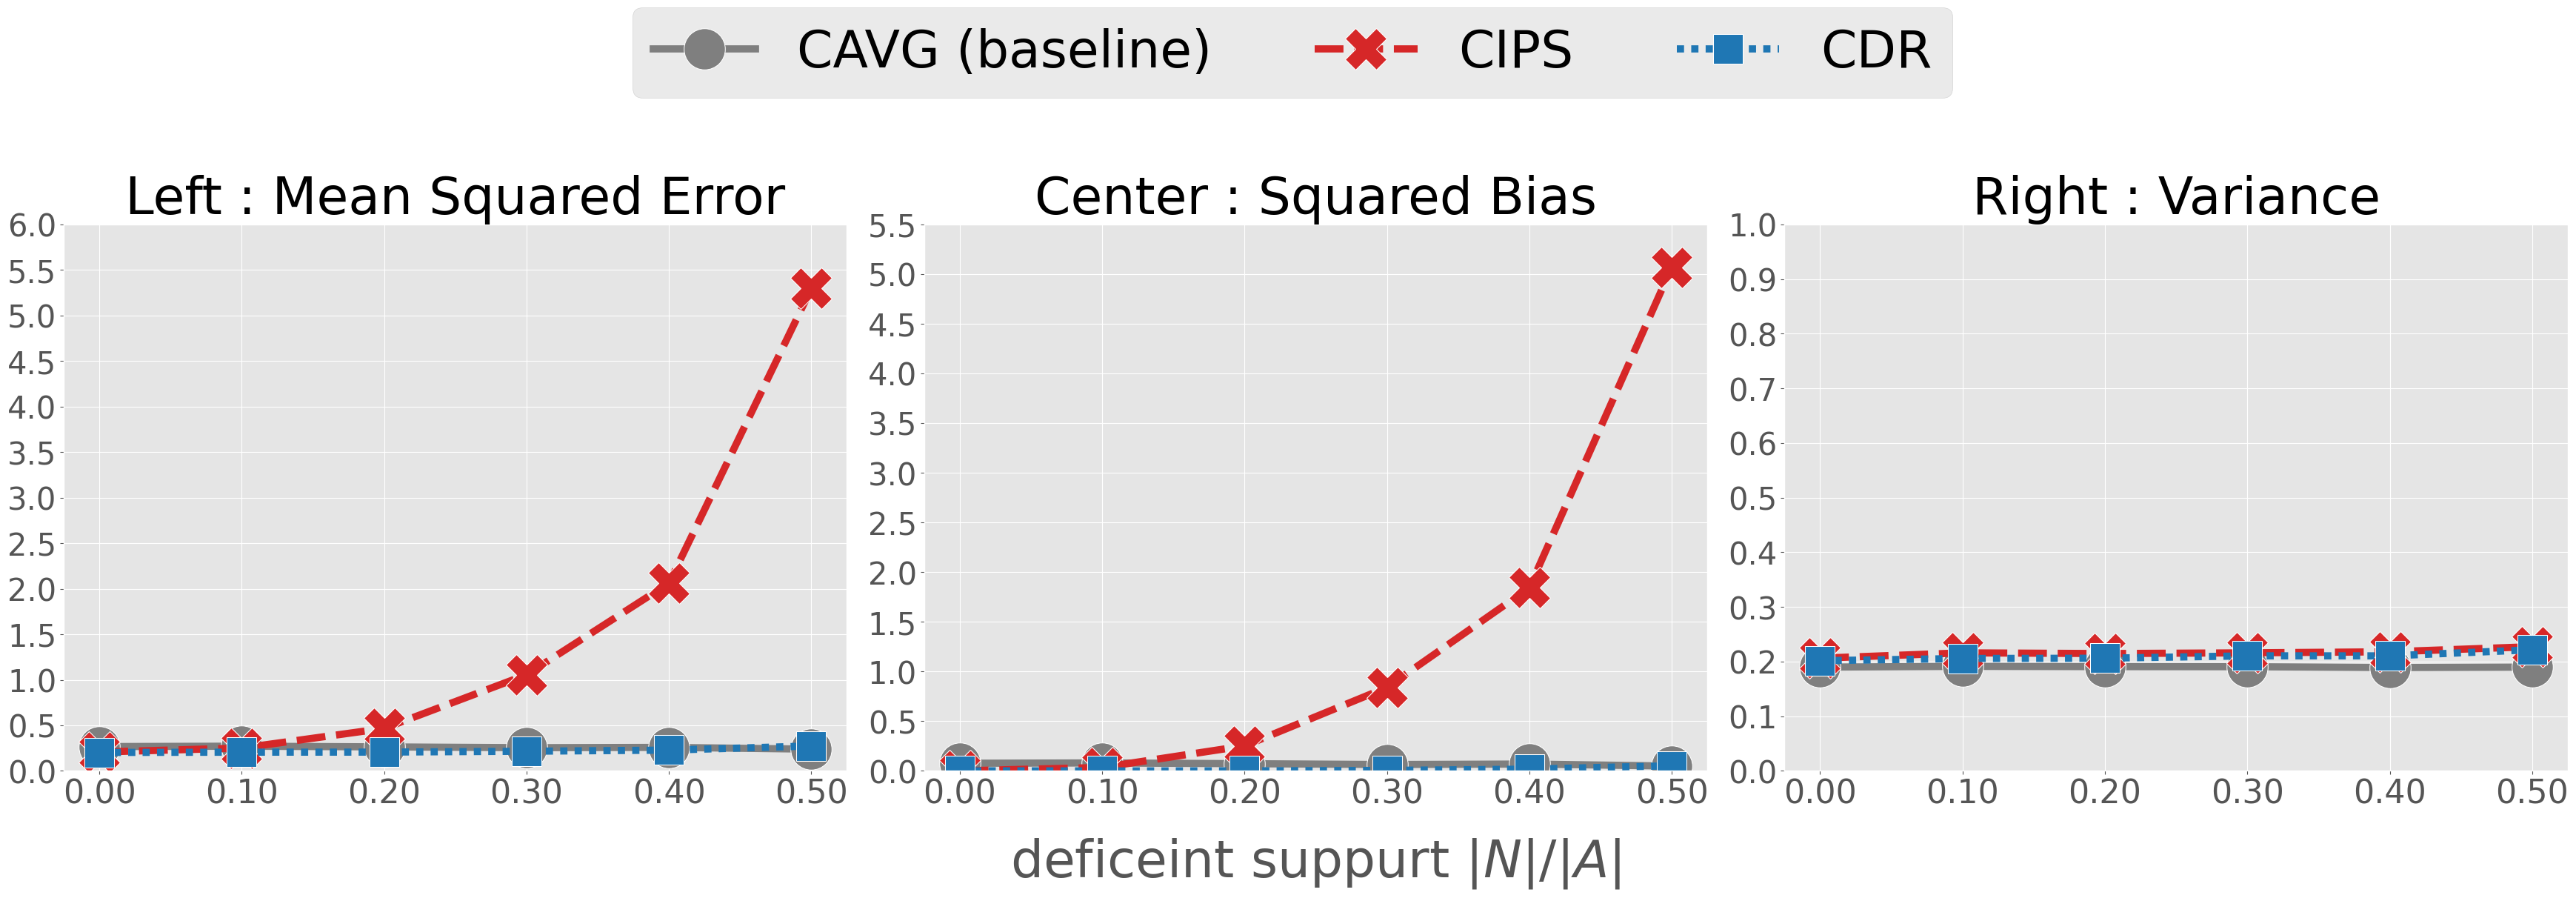

In [44]:
y_label_dict_k = {"se": "Left : Mean Squared Error", "bias": "Center : Squared Bias", "variance": "Right : Variance"}

fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_def_actions",  # x軸は k
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red", "tab:blue"],
        data=result_df_def_actions.query("est=='cavg' or est == 'cips' or est == 'cdr'")
    )
    ax.set_title(y_label_dict_k[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    if y == "se":
        ax.set_ylim(0.0, 6.0)
        ax.set_yticks(np.arange(0.0, 6.5, 0.5))
    elif y == "bias":
        ax.set_ylim(0.0, 5.5)
        ax.set_yticks(np.arange(0.0, 6.0, 0.5))
    elif y == "variance":
        ax.set_ylim(0.0, 1.0)
        ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"deficeint suppurt $|N| / |A|$", fontsize=50)  # x軸ラベル
    else:
        ax.set_xlabel(r"", fontsize=40)
    xticks = np.array(num_def_actions_list) / num_actions
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{x:.2f}" for x in xticks], fontsize=32)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["CAVG (baseline)", "CIPS", "CDR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")
plt.show()